In [2]:
import warnings
import pathlib
import os
import sys
import concurrent.futures
import re

import pandas as pd

from benzinga import news_data
from datetime import datetime
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning

warnings.filterwarnings("ignore")

In [3]:
api_key = '092fe3da34ad421f99c42265ce3a7cbd'

In [51]:
# project_folder = pathlib.Path(os.path.abspath("__file__")).resolve().parent.parent
# sys.path.insert(1, str(project_folder))


In [54]:
from portfolio_optimisation.classes.yahoo_parser import SP500Parser


In [55]:
yahoo_parser = SP500Parser()

start = '2013-01-01'
end = datetime.today().strftime('%Y-%m-%d')
stocks = yahoo_parser.download_sp500_data(start, end)

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2013-01-01 -> 2024-02-28)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


KeyError: 'Symbol'

In [ ]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def get_news(ticker, page, date_from, date_to, display_output="full"):
    news = paper.news(company_tickers=ticker, display_output=display_output, date_from=date_from, date_to=date_to, page=page, pagesize=100)
    if (len(news) == 0):
        return []
    df = pd.DataFrame(news)
    df['teaser'] = df['teaser'].apply(remove_html_tags)
    df['body'] = df['body'].apply(remove_html_tags)
    return df

def create_datasets_folder():
    if not os.path.exists('datasets'):
        os.makedirs('datasets')

def get_news_by_ticker(ticker):
    try:
        page = 0
        main_df = pd.DataFrame()
        date_from = start
        total = 0
        while True:
            if page > 100:
                date_from  = datetime.strptime(main_df['updated'].iloc[-1], "%a, %d %b %Y %H:%M:%S %z").strftime('%Y-%m-%d')
                page = 0
            news_df = get_news(ticker, page, date_from, today_date, 'full')
            if (len(news_df) == 0):
                break
            main_df = pd.concat([main_df, news_df], ignore_index=True)
            main_df = main_df.drop_duplicates(subset=['id'])
            page += 1
            total += 1
            print(f"{ticker} - {total} page. Added rows: {len(news_df)} total: {len(main_df)}")
        if ticker == 'BRK.B' or ticker == 'BRK.A':
            ticker = 'BRK-B'
        main_df.to_csv(f"datasets/news_sp_500_{ticker}.csv")
        return ticker
    except Exception as e:
        print(e)

def merge_all_in_one_file():
    main_df = pd.DataFrame()
    for ticker in tickers:
        if ticker == 'BRK.B':
            ticker = 'BRK-B'
        df = pd.read_csv(f"datasets/news_sp_500_{ticker}.csv")
        main_df = pd.concat([main_df, df], ignore_index=True)
        main_df = main_df.drop_duplicates(subset=['id'])
        os.remove(f"datasets/news_sp_500_{ticker}.csv")
    print(f"Rows in total {len(main_df)}")
    main_df.to_csv(f"datasets/news_sp_500.csv")

def run_concurent(max_workers=10):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(get_news_by_ticker, ticker) for ticker in tickers]
        for future in concurrent.futures.as_completed(futures):
            ticker = future.result()
            print(f"Ticker {ticker} done")

def check_all_files():
    for ticker in tickers:
        if ticker == 'BRK.B':
            ticker = 'BRK-B'
        df = pd.read_csv(f"datasets/news_sp_500_{ticker}.csv")
        if len(df) == 0:
            print(f"{ticker} - {len(df)}")

def zip_all_datasets():
    zf = zipfile.ZipFile('news_datasets.zip', mode='w')
    for ticker in tickers:
        if ticker == 'BRK.B':
            ticker = 'BRK-B'
        zf.write(f"datasets/news_sp_500_{ticker}.csv")
    zf.write(f"datasets/news_sp_500.csv")
    zf.close()

In [ ]:
main_df = pd.DataFrame()
today_date = datetime.today().strftime('%Y-%m-%d')
paper = news_data.News(api_key, log=False)
tickers = yahoo_parser.get_sp500_tickers()

In [ ]:
create_datasets_folder()
run_concurent()

Ticker AAL done
Ticker ABNB done
Ticker ACGL done
Ticker ABT done
Ticker ACN done
Ticker ADI done
Ticker ABBV done
Ticker ADBE done
Ticker A done
AAPL - 1 page. Added rows: 100 total: 29
Ticker ADP done
Ticker ADM done
Ticker ADSK done
Ticker AIZ done
Ticker AFL done
Ticker AIG done
Ticker AEP done
Ticker AEE done
Ticker AES done
Ticker AJG done
Ticker ALB done
Ticker ALL done
Ticker ALGN done
Ticker ALLE done
Ticker AMAT done
Ticker AMCR done
Ticker AKAM done
Ticker AMD done
Ticker AME done
Ticker AMT done
Ticker ANSS done
Ticker AMZN done
Ticker AMP done
AAPL - 2 page. Added rows: 100 total: 58
Ticker ANET done
Ticker AOS done
AMGN - 1 page. Added rows: 100 total: 28
Ticker APD done
Ticker AVGO done
Ticker AVY done
AMGN - 2 page. Added rows: 100 total: 60
Ticker AWK done
Ticker APTV done
Ticker ARE done
Ticker APH done
Ticker ATO done
Ticker APA done
Ticker AVB done
Ticker AXON done
Ticker AON done
Ticker AZO done
Ticker BALL done
Ticker BAC done
Ticker BAX done
AAPL - 3 page. Added 

In [ ]:
merge_all_in_one_file()

Rows in total 45407


In [ ]:
df_news = pd.read_csv('datasets/news_sp_500.csv').iloc[:,2:][['updated', 'stocks', 'body']].dropna()

df_news['stocks'] = df_news['stocks'].apply(eval).apply(lambda x: [entry['name'] for entry in x])

df_news = df_news.explode('stocks')

df_news['updated'] = pd.to_datetime(df_news['updated']).dt.tz_localize(None)

df_news['updated'] = df_news['updated'].dt.date
df_news['updated'] = pd.to_datetime(df_news['updated'])

df_news.head()

,updated,stocks,body
1,2013-01-02,AAPL,Futures Up Strong on Fiscal Cliff Deal\nU.S. e...
1,2013-01-02,BROAD,Futures Up Strong on Fiscal Cliff Deal\nU.S. e...
1,2013-01-02,BZSUM,Futures Up Strong on Fiscal Cliff Deal\nU.S. e...
1,2013-01-02,CAR,Futures Up Strong on Fiscal Cliff Deal\nU.S. e...
1,2013-01-02,EARLY,Futures Up Strong on Fiscal Cliff Deal\nU.S. e...


In [ ]:
df_stocks = stocks[['Symbol', 'Adj Close']]
df_stocks['pct_diff'] = df_stocks.groupby('Symbol')['Adj Close'].pct_change() * 100
df_stocks = df_stocks.dropna().reset_index()
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

In [ ]:
df_merged = df_news.merge(df_stocks,
                          how='inner',
                          left_on=['updated', 'stocks'],
                          right_on=['Date', 'Symbol'])[['Symbol', 'body', 'pct_diff']]

In [ ]:
df.to_csv('datasets/merged.csv')

In [ ]:
df_merged = pd.read_csv('datasets/merged.csv')[['Symbol', 'body', 'pct_diff']]

In [ ]:
df_merged

,Symbol,body,pct_diff
0,AAPL,Microsoft (NASDAQ: MSFT) has purchased technol...,-1.262273
1,AAPL,Apple (NASDAQ: AAPL) is reportedly interested ...,-1.262273
2,AAPL,The year has opened with a bit of good news fo...,-1.262273
3,AAPL,"On Thursday, the NASDAQ stock market is appare...",-1.262273
4,AAPL,Sony (NYSE: SNE) is getting a lot of attention...,-1.262273
...,...,...,...
143526,EBAY,After Ford Motor (NYSE:F) decided to cut the o...,-1.572028
143527,F,After Ford Motor (NYSE:F) decided to cut the o...,1.991338
143528,WMT,After Ford Motor (NYSE:F) decided to cut the o...,0.333254
143529,WMT,Walmart Inc. (NYSE:WMT) announced on Tuesday e...,0.333254


In [103]:
import pandas as pd
import numpy as np
import nltk

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 

import re
from string import punctuation

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sprilut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sprilut/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [104]:
def text_to_wordlist(text, remove_stop_words=True, stem_words=False): 
    text = text.replace('\n', '')
    text = text.replace('\r\r', '')
    text = re.sub(r"[^A-Za-z0-9]", " ", text).lower()
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        stop_words = set(stopwords.words("english")) 
        word_tokens = word_tokenize(text) 
        text = [word for word in word_tokens if word not in stop_words] 
    
    # Optionally, shorten words to their stems
    if stem_words:
        # text = text.split()
        stemmer = SnowballStemmer('english')
        text = [stemmer.stem(word) for word in text]
    
    # Return a list of words
    return text

In [105]:
df_merged['body_preprocessed'] = df_merged['body'].apply(lambda x: text_to_wordlist(x, stem_words=True))

KeyboardInterrupt: 

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(
    input="content",
    tokenizer=text_to_wordlist,
    token_pattern=None,
)

X_train, X_test, y_train, y_test = train_test_split(df_merged, df_merged["pct_diff"], test_size=0.3)


X_train_body_vectorized = vectorizer.fit_transform(X_train["body"])
X_test_body_vectorized = vectorizer.transform(X_test["body"])

In [74]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(np.array(X_train['Symbol']).reshape(-1, 1))
X_train_proccesed = hstack([X_train_body_vectorized, X_train_encoded])

X_test_encoded = encoder.transform(np.array(X_test['Symbol']).reshape(-1, 1))
X_test_proccesed = hstack([X_test_body_vectorized, X_test_encoded])

In [75]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

model = CatBoostRegressor()

model.fit(X_train_proccesed, y_train)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_proccesed)),
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_proccesed)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test_proccesed)),
    'r2': r2_score(y_test, model.predict(X_test_proccesed)),
}
scores

Learning rate set to 0.084821
0:	learn: 3.5141730	total: 1.04s	remaining: 17m 20s
1:	learn: 3.4933734	total: 1.81s	remaining: 15m 3s
2:	learn: 3.4747799	total: 2.56s	remaining: 14m 10s
3:	learn: 3.4595400	total: 3.41s	remaining: 14m 9s
4:	learn: 3.4453526	total: 4.22s	remaining: 14m
5:	learn: 3.4327733	total: 5.1s	remaining: 14m 4s
6:	learn: 3.4229517	total: 5.99s	remaining: 14m 10s
7:	learn: 3.4136131	total: 6.86s	remaining: 14m 10s
8:	learn: 3.4062459	total: 7.7s	remaining: 14m 8s
9:	learn: 3.3993854	total: 8.55s	remaining: 14m 6s
10:	learn: 3.3927377	total: 9.45s	remaining: 14m 9s
11:	learn: 3.3863389	total: 10.4s	remaining: 14m 14s
12:	learn: 3.3814835	total: 11.3s	remaining: 14m 18s
13:	learn: 3.3767415	total: 12.2s	remaining: 14m 17s
14:	learn: 3.3728779	total: 13.1s	remaining: 14m 19s
15:	learn: 3.3687898	total: 13.9s	remaining: 14m 15s
16:	learn: 3.3645428	total: 14.8s	remaining: 14m 13s
17:	learn: 3.3603848	total: 15.6s	remaining: 14m 9s
18:	learn: 3.3569955	total: 16.4s	remai

{'mean_squared_error': 10.48606994087936,
 'mean_absolute_percentage_error': 6558457133422.015,
 'r2': 0.15355473743178216}

In [76]:
from xgboost import XGBRegressor
model = XGBRegressor()

model.fit(X_train_proccesed, y_train)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_proccesed)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test_proccesed)),
    'r2': r2_score(y_test, model.predict(X_test_proccesed)),
}
scores

{'mean_squared_error': 10.668367248496512,
 'mean_absolute_percentage_error': 6499537059397.321,
 'r2': 0.13883953018240736}

In [77]:
from lightgbm import LGBMRegressor
 
model = LGBMRegressor(metric='mse')

model.fit(X_train_proccesed, y_train)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_proccesed)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test_proccesed)),
    'r2': r2_score(y_test, model.predict(X_test_proccesed)),
}
scores

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.592813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1902983
[LightGBM] [Info] Number of data points in the train set: 100471, number of used features: 40428
[LightGBM] [Info] Start training from score 0.107487


{'mean_squared_error': 10.633911638477876,
 'mean_absolute_percentage_error': 6149678652337.21,
 'r2': 0.14162081888576372}

In [24]:
df_merged[df_merged['Symbol'] == 'AAPL']

# Only AAPL

In [58]:
df_aapl = df_merged[df_merged['Symbol'] == 'AAPL'][['body', 'pct_diff']]

In [59]:
df_aapl['body_preprocessed'] = df_aapl['body'].apply(lambda x: text_to_wordlist(x, stem_words=True))

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(
    input="content",
    tokenizer=text_to_wordlist,
    token_pattern=None,
)

X_train, X_test, y_train, y_test = train_test_split(df_aapl, df_aapl["pct_diff"], test_size=0.3)


X_train_body_vectorized = vectorizer.fit_transform(X_train["body"])
X_test_body_vectorized = vectorizer.transform(X_test["body"])

In [62]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

model = CatBoostRegressor()

model.fit(X_train_body_vectorized, y_train)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_body_vectorized)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test_body_vectorized)),
    'r2': r2_score(y_test, model.predict(X_test_body_vectorized)),
}
scores

Learning rate set to 0.057529
0:	learn: 2.0949785	total: 295ms	remaining: 4m 54s
1:	learn: 2.0930747	total: 445ms	remaining: 3m 42s
2:	learn: 2.0916982	total: 558ms	remaining: 3m 5s
3:	learn: 2.0890859	total: 669ms	remaining: 2m 46s
4:	learn: 2.0873476	total: 774ms	remaining: 2m 34s
5:	learn: 2.0856431	total: 887ms	remaining: 2m 26s
6:	learn: 2.0846084	total: 996ms	remaining: 2m 21s
7:	learn: 2.0831892	total: 1.11s	remaining: 2m 17s
8:	learn: 2.0820847	total: 1.23s	remaining: 2m 15s
9:	learn: 2.0809140	total: 1.34s	remaining: 2m 13s
10:	learn: 2.0787592	total: 1.47s	remaining: 2m 12s
11:	learn: 2.0783463	total: 1.58s	remaining: 2m 10s
12:	learn: 2.0773026	total: 1.69s	remaining: 2m 8s
13:	learn: 2.0765409	total: 1.81s	remaining: 2m 7s
14:	learn: 2.0752359	total: 1.92s	remaining: 2m 5s
15:	learn: 2.0740933	total: 2.03s	remaining: 2m 4s
16:	learn: 2.0734786	total: 2.14s	remaining: 2m 3s
17:	learn: 2.0724447	total: 2.25s	remaining: 2m 2s
18:	learn: 2.0702818	total: 2.36s	remaining: 2m 1s


{'mean_squared_error': 4.1158709165198495,
 'mean_absolute_percentage_error': 3116774256794.7705,
 'r2': 0.05578023078144623}

In [63]:
from xgboost import XGBRegressor
model = XGBRegressor()

model.fit(X_train_body_vectorized, y_train)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_body_vectorized)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test_body_vectorized)),
    'r2': r2_score(y_test, model.predict(X_test_body_vectorized)),
}
scores

{'mean_squared_error': 4.381126780122696,
 'mean_absolute_percentage_error': 6707651970997.321,
 'r2': -0.005071976538681078}

In [64]:
from lightgbm import LGBMRegressor
 
model = LGBMRegressor(metric='mse')

model.fit(X_train_body_vectorized, y_train)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test_body_vectorized)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test_body_vectorized)),
    'r2': r2_score(y_test, model.predict(X_test_body_vectorized)),
}
scores

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407666
[LightGBM] [Info] Number of data points in the train set: 8607, number of used features: 8083
[LightGBM] [Info] Start training from score 0.089547


{'mean_squared_error': 4.224062468412791,
 'mean_absolute_percentage_error': 7944728957177.876,
 'r2': 0.030960064106703045}

Merge all news of one week for every ticker in one string 

In [34]:
import ast
df_news = pd.read_csv('../../datasets/news_sp_500_embeddings.csv').iloc[:,2:][['updated', 'stocks', 'body', 'title_embeddings']].dropna()

df_news['stocks'] = df_news['stocks'].apply(eval).apply(lambda x: [entry['name'] for entry in x])
from sentence_transformers import SentenceTransformer
import pandas as pd

model = SentenceTransformer("all-MiniLM-L6-v2")
df_news['title_embeddings'] = df_news['title_embeddings'].apply(ast.literal_eval)


In [67]:
df_embedded_news = df_news.join(pd.DataFrame(df_news['title_embeddings'].tolist(), columns=[f'title_embedding_{i}' for i in range(384)]))

df_embedded_news = df_embedded_news.explode('stocks')

df_embedded_news['updated'] = pd.to_datetime(df_embedded_news['updated']).dt.date

df_embedded_news.head()

,updated,stocks,body,title_embeddings,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3,title_embedding_4,title_embedding_5,...,title_embedding_374,title_embedding_375,title_embedding_376,title_embedding_377,title_embedding_378,title_embedding_379,title_embedding_380,title_embedding_381,title_embedding_382,title_embedding_383
0,2012-06-26,CIT,"SANTA CLARA, CA--(Marketwire - July 27, 2009) ...","[0.027524035423994064, -0.028870563954114914, ...",0.027524,-0.028871,-0.060342,0.053199,0.046198,-0.037971,...,0.036538,-0.019922,-0.055372,0.011424,-0.067690,-0.015036,0.037755,-0.089164,-0.005867,-0.016719
0,2012-06-26,CME,"SANTA CLARA, CA--(Marketwire - July 27, 2009) ...","[0.027524035423994064, -0.028870563954114914, ...",0.027524,-0.028871,-0.060342,0.053199,0.046198,-0.037971,...,0.036538,-0.019922,-0.055372,0.011424,-0.067690,-0.015036,0.037755,-0.089164,-0.005867,-0.016719
0,2012-06-26,ISRG,"SANTA CLARA, CA--(Marketwire - July 27, 2009) ...","[0.027524035423994064, -0.028870563954114914, ...",0.027524,-0.028871,-0.060342,0.053199,0.046198,-0.037971,...,0.036538,-0.019922,-0.055372,0.011424,-0.067690,-0.015036,0.037755,-0.089164,-0.005867,-0.016719
0,2012-06-26,MSFT,"SANTA CLARA, CA--(Marketwire - July 27, 2009) ...","[0.027524035423994064, -0.028870563954114914, ...",0.027524,-0.028871,-0.060342,0.053199,0.046198,-0.037971,...,0.036538,-0.019922,-0.055372,0.011424,-0.067690,-0.015036,0.037755,-0.089164,-0.005867,-0.016719
1,2012-06-26,AAPL,"ATLANTA, GA--(Marketwire - July 27, 2009) - M...","[0.021889986470341682, -0.0276284571737051, 0....",0.021890,-0.027628,0.035083,0.050099,0.067462,0.026903,...,-0.002254,-0.030781,-0.083482,-0.012103,-0.065227,0.015232,-0.005367,-0.121527,-0.053555,0.001270


In [57]:
df_embedded_news.head()

,updated,stocks,body,title_embeddings
0,"Tue, 26 Jun 2012 20:37:59 -0400","[CIT, CME, ISRG, MSFT]","SANTA CLARA, CA--(Marketwire - July 27, 2009) ...","[0.027524035423994064, -0.028870563954114914, ..."
1,"Tue, 26 Jun 2012 20:38:47 -0400","[AAPL, MSFT]","ATLANTA, GA--(Marketwire - July 27, 2009) - M...","[0.021889986470341682, -0.0276284571737051, 0...."
2,"Tue, 26 Jun 2012 21:17:44 -0400","[CEO, ISP, MSFT, PC, PM, S]","NASHVILLE, TN--(Marketwire - August 7, 2009) -...","[-0.08455029875040054, -0.062004029750823975, ..."
3,"Tue, 26 Jun 2012 22:27:25 -0400","[C, FL, FREE, MSFT, WFC]","MIAMI, FL--(Marketwire - August 13, 2009) - S...","[-0.02535986341536045, -0.05817781761288643, 0..."
4,"Sun, 12 Apr 2020 22:59:07 -0400","[AMZN, GOOG, GOOGL, MSFT, NFLX, APPLE]","Apple Inc. (NASDAQ:APPLE) has the ""brightest"" ...","[-0.005124563351273537, -0.06212545558810234, ..."


In [71]:
df_news_daily = df_embedded_news.groupby(['updated', 'stocks']).agg({
    'body': '\n'.join,  # Concatenate the 'body' texts
    **{f'title_embedding_{i}': 'sum' for i in range(384)}  # Sum the embeddings
}).reset_index()

In [85]:
df_news_daily['updated'] = pd.to_datetime(df_news_daily['updated'])

In [91]:
df_news_daily['updated']

0        2012-06-26
1        2012-06-26
2        2012-06-26
3        2012-06-26
4        2012-06-26
            ...    
343817   2023-10-30
343818   2023-10-30
343819   2023-10-30
343820   2023-10-30
343821   2023-10-30
Name: updated, Length: 343822, dtype: datetime64[ns]

In [60]:
stocks = pd.read_csv('../../datasets/sp500_historical_data.csv')
stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,A,20.154915,22.389128,22.625179,22.267525,22.453505,3815561.0
1,2010-01-05,A,19.935982,22.145924,22.331903,22.002861,22.324751,4186031.0
2,2010-01-06,A,19.865147,22.067240,22.174536,22.002861,22.067240,3243779.0
3,2010-01-07,A,19.839396,22.038628,22.045780,21.816881,22.017166,3095172.0
4,2010-01-08,A,19.832952,22.031473,22.067240,21.745352,21.917025,3733918.0


In [61]:
import pandas as pd
import pandas as pd
from ta.trend import MACD

def apply_features(group):
    group.index = pd.to_datetime(group.index)

    # Compute lag features, moving averages, etc., for the group
    for lag in range(1, 4):
        group[f'lag_{lag}'] = group['Close'].shift(lag)
    group['weekly_return'] = group['Close'].pct_change(5)
    group['5_day_MA'] = group['Close'].rolling(window=5).mean()
    group['20_day_MA'] = group['Close'].rolling(window=20).mean()
    group['5_day_volatility'] = group['Close'].rolling(window=5).std()
    group['momentum'] = group['Close'] - group['Close'].shift(1)
    
    # MACD, ensuring you handle NaNs as per your strategy

    macd = MACD(close=group['Close'], window_slow=26, window_fast=12, window_sign=9)
    group['MACD'] = macd.macd()
    group['MACD_signal'] = macd.macd_signal()
    group['MACD_histogram'] = macd.macd_diff()

    # Adjusting for multi-stock data: adding week_of_year and month
    group['week_of_year'] = group.index.isocalendar().week
    group['month'] = group.index.month
    
    return group.dropna()  # Optionally drop NaNs

# Apply the function to each group and recombine
# data_grouped = data.groupby('Symbol').apply(apply_features)


In [93]:
df_stocks['Date'] = pd.to_datetime(stocks['Date'])
df_stocks['Date']

0         2010-01-04
1         2010-01-05
2         2010-01-06
3         2010-01-07
4         2010-01-08
             ...    
1668071   2011-03-09
1668072   2011-03-10
1668073   2011-03-11
1668074   2011-03-14
1668075   2011-03-15
Name: Date, Length: 1668076, dtype: datetime64[ns]

In [96]:
df_stocks = stocks.groupby('Symbol').apply(apply_features)
df_stocks.index = df_stocks.index.droplevel()
df_stocks.reset_index(inplace=True)
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

In [97]:
df_stocks['Date']

0         2010-02-22
1         2010-02-23
2         2010-02-24
3         2010-02-25
4         2010-02-26
             ...    
1668071   2023-12-22
1668072   2023-12-26
1668073   2023-12-27
1668074   2023-12-28
1668075   2023-12-29
Name: Date, Length: 1668076, dtype: datetime64[ns]

In [98]:
df_news_daily[df_news_daily['updated'] == '2012-06-26']

,updated,stocks,body,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3,title_embedding_4,title_embedding_5,title_embedding_6,...,title_embedding_374,title_embedding_375,title_embedding_376,title_embedding_377,title_embedding_378,title_embedding_379,title_embedding_380,title_embedding_381,title_embedding_382,title_embedding_383
0,2012-06-26,A,"SEATTLE, WA--(Marketwire - August 13, 2009) - ...",-5.284238,-2.101056,3.551047,5.982857,1.211795,1.173621,-5.063716,...,-0.284019,1.852075,-2.815040,-2.786377,-5.228143,0.569408,3.287033,-10.947952,-1.283497,1.939517
1,2012-06-26,AA,"MIAMI, FL--(Marketwire - August 10, 2009) - S...",-0.567423,0.315751,0.079416,0.488981,-0.146454,-0.247722,0.116838,...,0.106774,0.427669,-0.118824,-0.239287,-0.334364,0.259747,0.286064,-0.577445,-0.159232,0.310443
2,2012-06-26,AAPL,"ATLANTA, GA--(Marketwire - July 27, 2009) - M...",-0.266523,-0.147059,-0.021691,0.554440,0.150152,0.067609,0.195433,...,-0.056199,0.047999,-0.288400,-0.117951,-0.243835,0.000246,0.294981,-0.779376,-0.161593,0.433099
3,2012-06-26,AB,"CALGARY, ALBERTA--(Marketwire - Aug. 10, 2009)...",-0.164155,-0.050696,0.068519,0.068947,0.036772,-0.022416,-0.095819,...,-0.167836,-0.071627,-0.060205,-0.104727,-0.142073,0.091558,0.086255,-0.186246,0.050761,0.086058
4,2012-06-26,ABC,"NEW YORK, NY--(Marketwire - August 11, 2009) -...",0.013808,-0.035620,0.018263,0.020154,0.008426,0.010649,-0.083490,...,-0.005726,0.007294,-0.071323,-0.032109,0.004966,0.060148,0.047080,-0.104086,0.011362,0.072452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2012-06-26,WR,"TORONTO, ONTARIO--(Marketwire - Aug. 12, 2009)...",-0.050648,0.052743,-0.043582,-0.039524,-0.018140,-0.025819,-0.032059,...,-0.014026,0.057892,-0.067936,0.009181,-0.081342,-0.026208,-0.034369,-0.089492,0.002416,-0.015811
535,2012-06-26,WTI,"RENO, NEVADA--(Marketwire - Aug. 7, 2009) - Al...",-0.550506,0.096993,0.157352,0.813560,0.152765,0.147517,-0.476600,...,-0.341048,0.206011,-0.443947,-0.145867,-0.617663,-0.055263,0.389131,-0.837753,-0.120757,0.088333
536,2012-06-26,WTSLA,"LONDON--(Marketwire - August 10, 2009) - Benc...",-0.046724,-0.049330,-0.108788,0.060443,0.040825,0.061723,-0.038514,...,0.024394,0.089123,-0.010135,0.004550,0.015462,0.040004,0.037169,-0.102657,-0.026180,0.023287
537,2012-06-26,X,"MIAMI, FL--(Marketwire - August 10, 2009) - S...",-0.215943,0.016824,0.121533,0.380651,0.031851,-0.106945,-0.041261,...,0.026074,0.136953,-0.141581,-0.123215,-0.208789,-0.136191,0.258832,-0.408046,-0.186810,0.164548


In [99]:
df_merged = df_news_daily.merge(df_stocks,
                                how='inner',
                                left_on=['updated', 'stocks'],
                                right_on=['Date', 'Symbol'])


df_merged.drop(['stocks', 'updated'], axis=1, inplace=True)
df_merged.columns = df_merged.columns.str.lower()
df_merged

,body,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3,title_embedding_4,title_embedding_5,title_embedding_6,title_embedding_7,title_embedding_8,...,weekly_return,5_day_ma,20_day_ma,5_day_volatility,momentum,macd,macd_signal,macd_histogram,week_of_year,month
0,"SEATTLE, WA--(Marketwire - August 13, 2009) - ...",-5.284238,-2.101056,3.551047,5.982857,1.211795,1.173621,-5.063716,4.590652,-2.697218,...,-0.076792,27.816882,28.191703,0.835555,0.236052,-0.340785,-0.256492,-0.084293,1,1
1,"ATLANTA, GA--(Marketwire - July 27, 2009) - M...",-0.266523,-0.147059,-0.021691,0.554440,0.150152,0.067609,0.195433,0.210850,-0.187523,...,-0.026183,20.630786,20.527071,0.228801,0.045000,0.066816,0.067156,-0.000339,1,1
2,"VANCOUVER, BRITISH COLUMBIA--(Marketwire - Aug...",-0.044039,-0.024521,0.073883,0.055657,0.060926,0.043422,0.002931,-0.006896,-0.059161,...,-0.036053,37.382000,36.873500,0.643638,-0.329998,0.101339,0.057419,0.043920,1,1
3,"VANCOUVER, BRITISH COLUMBIA--(Marketwire - Aug...",0.002957,-0.049649,0.110712,0.019179,0.046692,0.046008,0.007282,0.045108,-0.011900,...,-0.050415,29.192000,30.914000,0.498467,-0.160002,-0.756842,-0.450417,-0.306424,1,1
4,"TORONTO, ONTARIO--(Marketwire - Aug. 10, 2009)...",-0.153213,-0.041022,0.018545,-0.009481,0.006550,-0.007050,-0.051779,0.013227,-0.099985,...,-0.040189,12.170000,12.289500,0.168671,0.170000,-0.026072,0.010217,-0.036289,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83900,Companies Reporting Before The Bell\n• HSBC Ho...,-0.058720,-0.020790,-0.000900,0.051844,-0.027587,-0.032041,-0.078451,-0.044412,0.028609,...,-0.013496,82.644000,83.460000,1.133614,0.520004,-0.081397,0.271369,-0.352766,1,1
83901,President Joe Biden issued a new executive ord...,0.000601,-0.087494,0.100261,-0.033929,0.000050,-0.018290,-0.033368,-0.044024,-0.015737,...,-0.001266,39.230000,39.939000,0.346339,0.670002,-0.495860,-0.413223,-0.082638,1,1
83902,GSK (NYSE:GSK) has reportedly taken an early l...,0.061705,-0.028781,-0.066157,-0.044429,-0.017998,0.042440,-0.060436,0.061649,-0.031410,...,0.012484,162.394000,160.135500,0.886865,1.850006,0.405979,0.069155,0.336823,1,1
83903,The third-quarter earnings season has largely ...,0.136967,-0.071233,-0.013635,0.124817,0.173383,0.011836,-0.034355,0.024761,0.053014,...,-0.032618,107.201999,109.576999,1.411831,0.329994,-1.607761,-1.132812,-0.474949,1,1


In [100]:
def text_to_wordlist(text, remove_stop_words=True, stem_words=False): 
    text = text.replace('\n', '')
    text = text.replace('\r', '')
    text = re.sub(r"[^A-Za-z0-9]", " ", text).lower()
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        stop_words = set(stopwords.words("english")) 
        word_tokens = word_tokenize(text) 
        text = [word for word in word_tokens if word not in stop_words] 
    
    # Optionally, shorten words to their stems
    if stem_words:
        # text = text.split()
        stemmer = SnowballStemmer('english')
        text = [stemmer.stem(word) for word in text]
    
    # Return a list of words
    return text

In [101]:
import inflect 
q = inflect.engine() 
  
def is_digit(string):
    try:
        float(string)
        return True
    except ValueError:
        return False 
        
def convert_num(text): 
    # split strings into list of texts 
    # temp_string = text.split() 
    # initialise empty list 
    new_str = [] 
  
    for word in text: 
        # if text is a digit, convert the digit 
        # to numbers and append into the new_str list 
        if is_digit(word): 
            temp = q.number_to_words(word) 
            new_str.append(temp) 
  
        # append the texts as it is 
        else: 
            new_str.append(word) 
  
    # join the texts of new_str to form a string 
    temp_str = ' '.join(new_str) 
    return temp_str 



def text_to_wordlist(text, remove_stop_words=True, stem_words=False, convert_numbers=True): 
    text = text.replace('\n', '')
    text = text.replace('\r', '')
    text = re.sub(r"[^A-Za-z0-9]", " ", text).lower()
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        stop_words = set(stopwords.words("english")) 
        word_tokens = word_tokenize(text) 
        text = [word for word in word_tokens if word not in stop_words] 
    
    # Optionally, shorten words to their stems
    if stem_words:
        stemmer = SnowballStemmer('english')
        text = [stemmer.stem(word) for word in text]
        
    if convert_numbers:
        text = convert_num(text)
        
    # Return a list of words
    return text


In [106]:
%%time
df_merged['body_preprocessed'] = df_merged['body'].apply(lambda x: text_to_wordlist(x, stem_words=True))

CPU times: user 15min 30s, sys: 6.99 s, total: 15min 37s
Wall time: 15min 48s


In [107]:
df_merged.drop('body', axis=1).to_csv('../../datasets/df_merged.csv')

In [108]:
import time

In [109]:
df_merged.drop("body", axis=1, inplace=True)

In [110]:
df_merged.head()

,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3,title_embedding_4,title_embedding_5,title_embedding_6,title_embedding_7,title_embedding_8,title_embedding_9,...,5_day_ma,20_day_ma,5_day_volatility,momentum,macd,macd_signal,macd_histogram,week_of_year,month,body_preprocessed
0,-5.284238,-2.101056,3.551047,5.982857,1.211795,1.173621,-5.063716,4.590652,-2.697218,-1.847017,...,27.816882,28.191703,0.835555,0.236052,-0.340785,-0.256492,-0.084293,1,1,"[seattl, wa, marketwir, august, whitepag, www,..."
1,-0.266523,-0.147059,-0.021691,0.554440,0.150152,0.067609,0.195433,0.210850,-0.187523,-0.118193,...,20.630786,20.527071,0.228801,0.045000,0.066816,0.067156,-0.000339,1,1,"[atlanta, ga, marketwir, juli, market, puls, p..."
2,-0.044039,-0.024521,0.073883,0.055657,0.060926,0.043422,0.002931,-0.006896,-0.059161,0.043806,...,37.382000,36.873500,0.643638,-0.329998,0.101339,0.057419,0.043920,1,1,"[vancouv, british, columbia, marketwir, aug, t..."
3,0.002957,-0.049649,0.110712,0.019179,0.046692,0.046008,0.007282,0.045108,-0.011900,0.078266,...,29.192000,30.914000,0.498467,-0.160002,-0.756842,-0.450417,-0.306424,1,1,"[vancouv, british, columbia, marketwir, aug, f..."
4,-0.153213,-0.041022,0.018545,-0.009481,0.006550,-0.007050,-0.051779,0.013227,-0.099985,-0.007425,...,12.170000,12.289500,0.168671,0.170000,-0.026072,0.010217,-0.036289,1,1,"[toronto, ontario, marketwir, aug, editor, not..."


In [118]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(df_merged.drop(['date', 'symbol', 'weekly_return'], axis=1),
                                                    df_merged["weekly_return"],
                                                    test_size=0.3)


vectorizer = TfidfVectorizer(
    input="content",
    token_pattern=None,
    lowercase=False,
)

X_train = vectorizer.fit_transform(X_train["body_preprocessed"])
X_test = vectorizer.transform(X_test["body_preprocessed"])


model = CatBoostRegressor()

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

scores = {
    'mean_squared_error': mean_squared_error(y_test, model.predict(X_test)),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, model.predict(X_test)),
    'r2': r2_score(y_test, model.predict(X_test)),
}
print(scores)

TypeError: first argument must be string or compiled pattern

In [126]:
df_merged['body_preprocessed'] = df_merged['body_preprocessed'].apply(lambda x: ' '.join(x)) 

In [146]:
print(df_merged['weekly_return'].dtypes)
df_merged.reset_index(drop=True, inplace=True)

float64


In [149]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

# Assuming vectorizer is defined outside the snippet

# Define a ColumnTransformer to handle both text and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(tokenizer=lambda x: x.split()), 'body_preprocessed'),  # Text feature
        # Add other numeric features here if any
        # ('numeric', 'passthrough', ['numeric_feature1', 'numeric_feature2']),
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['date', 'symbol', 'weekly_return', 'index'], axis=1),
    df_merged["weekly_return"],
    test_size=0.3
)

# Preprocess data
X_train_processed = pipeline.fit_transform(X_train)
# X_test_processed = pipeline.transform(X_test)

# # Initialize and train the model
# model = CatBoostRegressor()
# model.fit(X_train_processed, y_train)

# # Make predictions
# y_pred = model.predict(X_test_processed)

# # Calculate scores
# scores = {
#     'mean_squared_error': mean_squared_error(y_test, y_pred),
#     'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, y_pred),
#     'r2': r2_score(y_test, y_pred),
# }
# print(scores)


In [151]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

# Assuming vectorizer is defined outside the snippet

# Define a ColumnTransformer to handle both text and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'body_preprocessed'),  # Text feature
        # Add other numeric features here if any
        # ('numeric', 'passthrough', ['numeric_feature1', 'numeric_feature2']),
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['date', 'symbol', 'weekly_return', 'index'], axis=1),
    df_merged["weekly_return"],
    test_size=0.3
)
# Preprocess data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Initialize and train the model
model = CatBoostRegressor()
model.fit(X_train_processed, y_train)

# Make predictions
y_pred = model.predict(X_test_processed)

# Calculate scores
scores = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred),
}
print(scores)


Learning rate set to 0.077923
0:	learn: 0.0545652	total: 3.25s	remaining: 54m 3s
1:	learn: 0.0527452	total: 6.26s	remaining: 52m 2s
2:	learn: 0.0511125	total: 9.42s	remaining: 52m 10s
3:	learn: 0.0496591	total: 12.5s	remaining: 51m 41s
4:	learn: 0.0483723	total: 14.7s	remaining: 48m 38s
5:	learn: 0.0471916	total: 16.8s	remaining: 46m 29s
6:	learn: 0.0461375	total: 18.8s	remaining: 44m 33s
7:	learn: 0.0452119	total: 21s	remaining: 43m 19s
8:	learn: 0.0443052	total: 23.2s	remaining: 42m 39s
9:	learn: 0.0435104	total: 25.4s	remaining: 41m 56s
10:	learn: 0.0428204	total: 27.4s	remaining: 41m 6s
11:	learn: 0.0420900	total: 29.4s	remaining: 40m 23s
12:	learn: 0.0414552	total: 31.7s	remaining: 40m 7s
13:	learn: 0.0408502	total: 33.8s	remaining: 39m 43s
14:	learn: 0.0403586	total: 36.3s	remaining: 39m 42s
15:	learn: 0.0398627	total: 38.4s	remaining: 39m 21s
16:	learn: 0.0394039	total: 40.6s	remaining: 39m 8s
17:	learn: 0.0389950	total: 42.6s	remaining: 38m 44s
18:	learn: 0.0385941	total: 44.7s

In [160]:
pipeline.get_feature_names_out()

array(['text__aa', 'text__aaa', 'text__aaaa', ...,
       'remainder__macd_histogram', 'remainder__week_of_year',
       'remainder__month'], dtype=object)

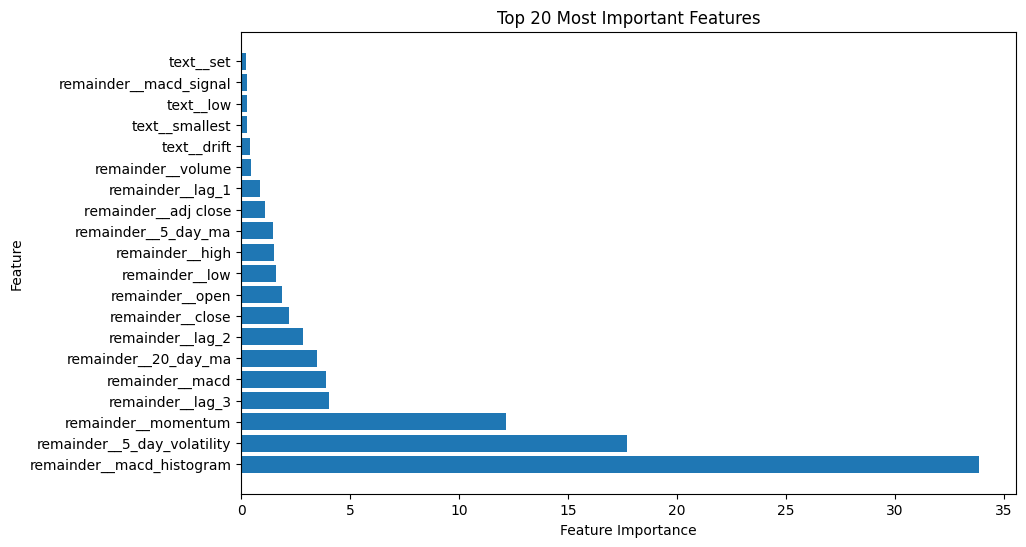

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [161]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = model.feature_importances_

# Get the indices of the top 20 most important features
top_20_indices = feature_importances.argsort()[-20:][::-1]

# Get the names of the top 20 most important features
top_20_features = pipeline.get_feature_names_out()[top_20_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_20_features)), feature_importances[top_20_indices], align='center')
plt.yticks(range(len(top_20_features)), top_20_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.show()


In [163]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['date', 'symbol', 'weekly_return', 'index', 'body_preprocessed'], axis=1),
    df_merged["weekly_return"],
    test_size=0.3
)

# Initialize and train the model
model_without_nlp = CatBoostRegressor()
model_without_nlp.fit(X_train, y_train)

# Make predictions
y_pred = model_without_nlp.predict(X_test)

# Calculate scores
scores = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred),
}
print(scores)


Learning rate set to 0.077923
0:	learn: 0.0546503	total: 41.6ms	remaining: 41.6s
1:	learn: 0.0528746	total: 77.2ms	remaining: 38.5s
2:	learn: 0.0512783	total: 113ms	remaining: 37.7s
3:	learn: 0.0498380	total: 159ms	remaining: 39.5s
4:	learn: 0.0485121	total: 198ms	remaining: 39.4s
5:	learn: 0.0473501	total: 231ms	remaining: 38.2s
6:	learn: 0.0462720	total: 262ms	remaining: 37.1s
7:	learn: 0.0452906	total: 286ms	remaining: 35.5s
8:	learn: 0.0444043	total: 308ms	remaining: 34s
9:	learn: 0.0436033	total: 332ms	remaining: 32.9s
10:	learn: 0.0428618	total: 356ms	remaining: 32s
11:	learn: 0.0421778	total: 382ms	remaining: 31.5s
12:	learn: 0.0415853	total: 405ms	remaining: 30.8s
13:	learn: 0.0410225	total: 431ms	remaining: 30.4s
14:	learn: 0.0404756	total: 454ms	remaining: 29.8s
15:	learn: 0.0400066	total: 476ms	remaining: 29.3s
16:	learn: 0.0395383	total: 503ms	remaining: 29.1s
17:	learn: 0.0391016	total: 526ms	remaining: 28.7s
18:	learn: 0.0386878	total: 552ms	remaining: 28.5s
19:	learn: 0.

In [164]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

# Assuming vectorizer is defined outside the snippet

# Define a ColumnTransformer to handle both text and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'body_preprocessed'),  # Text feature
        # Add other numeric features here if any
        # ('numeric', 'passthrough', ['numeric_feature1', 'numeric_feature2']),
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Define the pipeline
pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
])

df_merged_without_emb = df_merged.drop(df_merged.filter(regex='^title_embeddings').columns, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_merged_without_emb.drop(['date', 'symbol', 'weekly_return', 'index'], axis=1),
    df_merged_without_emb["weekly_return"],
    test_size=0.3
)
# Preprocess data
X_train_processed = pipeline_2.fit_transform(X_train)
X_test_processed = pipeline_2.transform(X_test)

# Initialize and train the model
model = CatBoostRegressor()
model.fit(X_train_processed, y_train)

# Make predictions
y_pred = model.predict(X_test_processed)

# Calculate scores
scores = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'mean_absolute_percentage_error': mean_absolute_percentage_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred),
}
print(scores)


Learning rate set to 0.077923
0:	learn: 0.0550001	total: 2.45s	remaining: 40m 46s
1:	learn: 0.0531795	total: 4.77s	remaining: 39m 41s
2:	learn: 0.0515745	total: 7.4s	remaining: 40m 59s
3:	learn: 0.0500825	total: 10.1s	remaining: 42m 5s
4:	learn: 0.0488084	total: 12.3s	remaining: 40m 51s
5:	learn: 0.0476531	total: 14.7s	remaining: 40m 39s
6:	learn: 0.0465489	total: 17s	remaining: 40m 4s
7:	learn: 0.0455950	total: 19.3s	remaining: 39m 47s
8:	learn: 0.0446969	total: 21.8s	remaining: 39m 54s
9:	learn: 0.0438812	total: 24.2s	remaining: 39m 54s
10:	learn: 0.0431629	total: 26.4s	remaining: 39m 30s
11:	learn: 0.0425119	total: 28.6s	remaining: 39m 11s
12:	learn: 0.0418735	total: 30.8s	remaining: 38m 58s
13:	learn: 0.0413062	total: 33s	remaining: 38m 43s
14:	learn: 0.0407414	total: 35.4s	remaining: 38m 45s
15:	learn: 0.0402072	total: 37.7s	remaining: 38m 38s
16:	learn: 0.0397436	total: 39.7s	remaining: 38m 16s
17:	learn: 0.0392889	total: 41.9s	remaining: 38m 6s
18:	learn: 0.0388886	total: 44.4s	